In [135]:
# https://www.pymc.io/projects/examples/en/latest/howto/spline.html

from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from patsy import dmatrix

In [136]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 8927
az.style.use("arviz-darkgrid")

In [137]:
gdp_data = pd.read_csv("../../data/a0_combinedQuarterly.csv", index_col=[0])
gdp_data.dropna(inplace=True)
gdp_data.describe()

,gdp_total,imports_goods_services,household_cons,gov_consumption,investments,gpd_invest_business_households,gov_invest,change_supply,exports_goods_services,BeloningSeizoengecorrigeerd_2,Loonkosten_7,BeloningVanWerknemers_8
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,164370.571429,103836.053571,76470.401786,40046.089286,33611.366071,27418.991071,6175.812500,233.883929,117717.750000,76728.241071,76055.178571,3.953571
std,20727.329406,30548.566795,5735.740015,6566.415212,5610.589303,5267.406575,687.061015,762.493051,35360.715797,19489.944176,20125.357112,2.553815
min,119388.000000,49327.000000,59897.000000,27660.000000,22683.000000,17543.000000,4352.000000,-1521.000000,56936.000000,42079.000000,39949.000000,-1.800000
25%,149229.250000,77738.250000,75539.750000,34876.500000,30126.000000,23938.250000,6011.000000,-323.250000,86319.500000,63635.750000,61267.750000,1.900000
50%,166605.000000,101920.500000,77213.500000,42865.000000,31892.500000,25869.000000,6310.000000,166.000000,114767.000000,77913.000000,75122.500000,4.000000
75%,177305.500000,130663.750000,78932.750000,43757.250000,37251.500000,30446.000000,6631.000000,821.250000,146576.500000,86165.250000,89808.000000,5.600000
max,203572.000000,154851.000000,87547.000000,52436.000000,62153.000000,55999.000000,7437.000000,2432.000000,179048.000000,124645.000000,131673.000000,9.000000


In [138]:
gdp_data.head()

,gdp_total,imports_goods_services,household_cons,gov_consumption,investments,gpd_invest_business_households,gov_invest,change_supply,exports_goods_services,BeloningSeizoengecorrigeerd_2,Loonkosten_7,BeloningVanWerknemers_8
4/1/1996,119388.0,49327.0,59897.0,27660.0,22683.0,18307.0,4352.0,820.0,57253.0,42079.0,39949.0,4.6
7/1/1996,120719.0,49605.0,60203.0,27837.0,24149.0,19564.0,4555.0,853.0,56936.0,42764.0,47685.0,4.0
10/1/1996,122410.0,50984.0,60857.0,28075.0,24906.0,20299.0,4567.0,799.0,58409.0,43266.0,40482.0,3.7
1/1/1997,123280.0,52800.0,61743.0,28262.0,26077.0,21296.0,4736.0,447.0,59372.0,43911.0,42792.0,3.3
4/1/1997,124625.0,54295.0,62386.0,28552.0,25593.0,21100.0,4443.0,197.0,61933.0,44418.0,42212.0,6.0


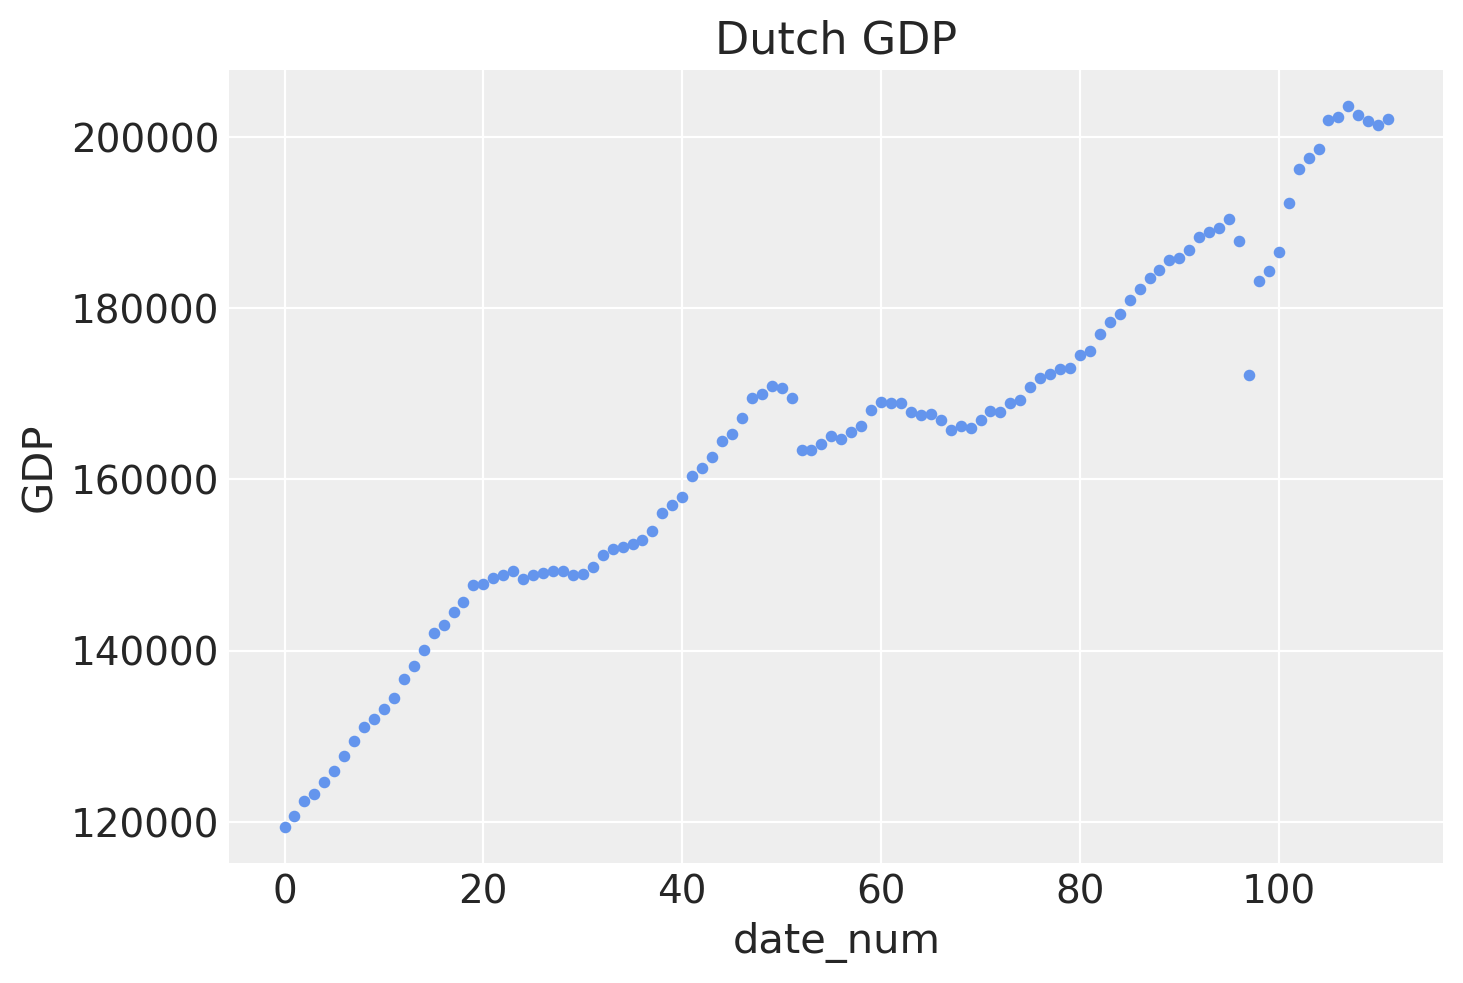

In [139]:
gdp_data['date'] = gdp_data.index
gdp_data['date_num'] = np.arange(0, gdp_data.shape[0])
gdp_data.plot.scatter(
    "date_num", "gdp_total", color="cornflowerblue", s=10, title="Dutch GDP", ylabel="GDP"
);

In [140]:
num_knots = 3
knot_list = np.quantile(gdp_data.date_num, np.linspace(0, 1, num_knots))
knot_list

array([  0. ,  55.5, 111. ])

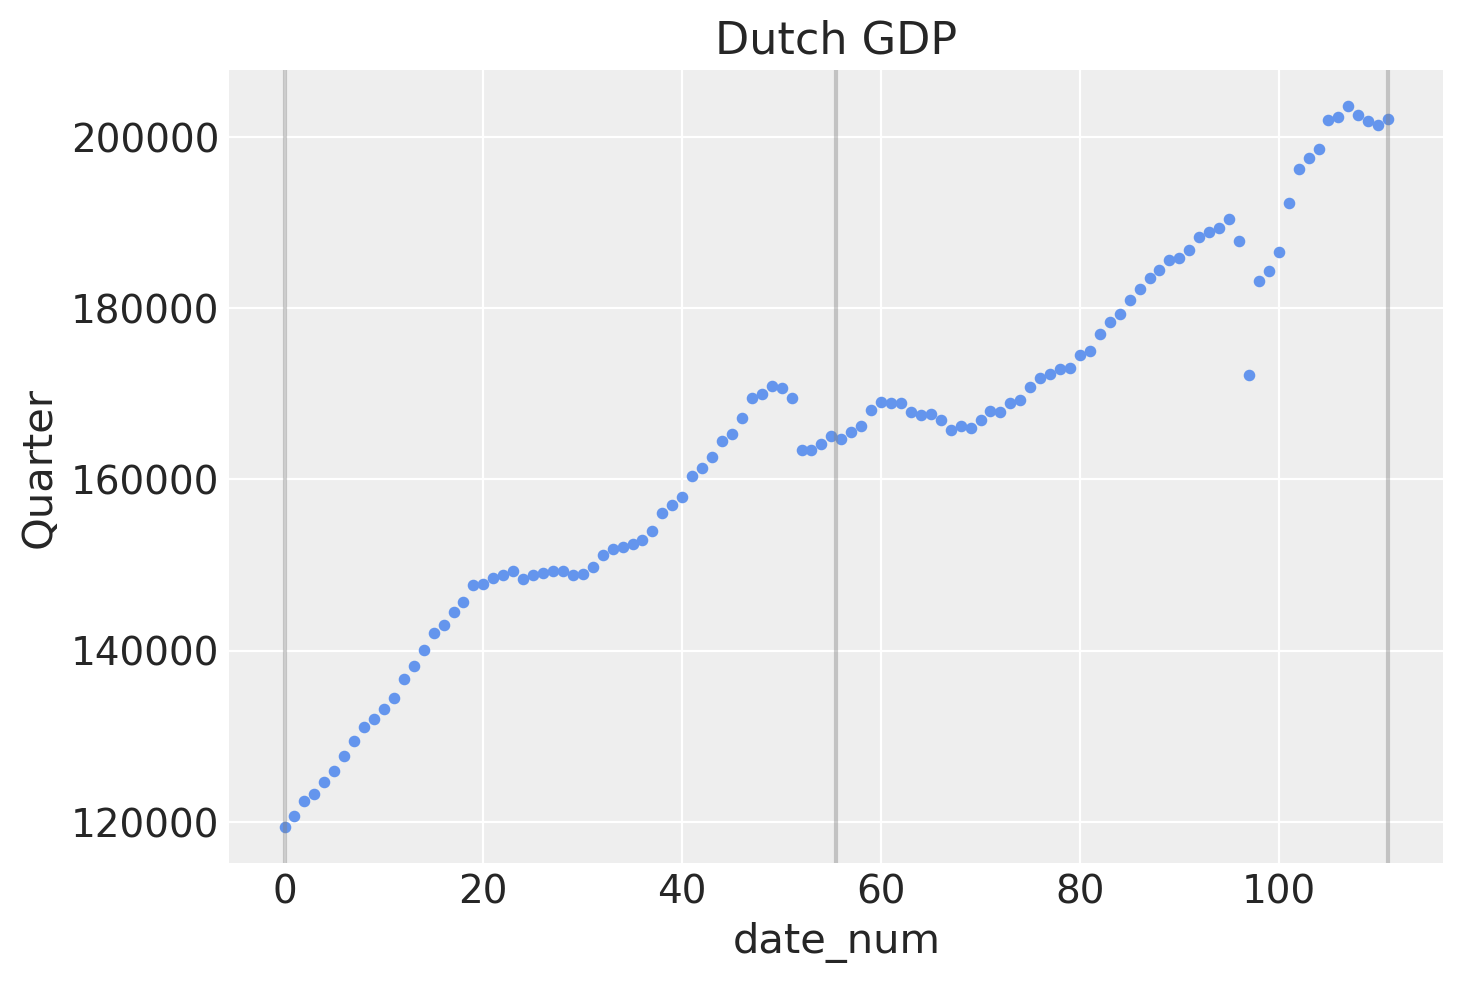

In [141]:
gdp_data.plot.scatter(
    "date_num", "gdp_total", color="cornflowerblue", s=10, title="Dutch GDP", ylabel="Quarter"
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

In [142]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": gdp_data.date_num.values, "knots": knot_list[1:-1]},
)
B

DesignMatrix with shape (112, 5)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]']
  Terms:
    'bs(year, knots=knots, degree=3, include_intercept=True)' (columns 0:5)
  (to view full data, use np.asarray(this_obj))

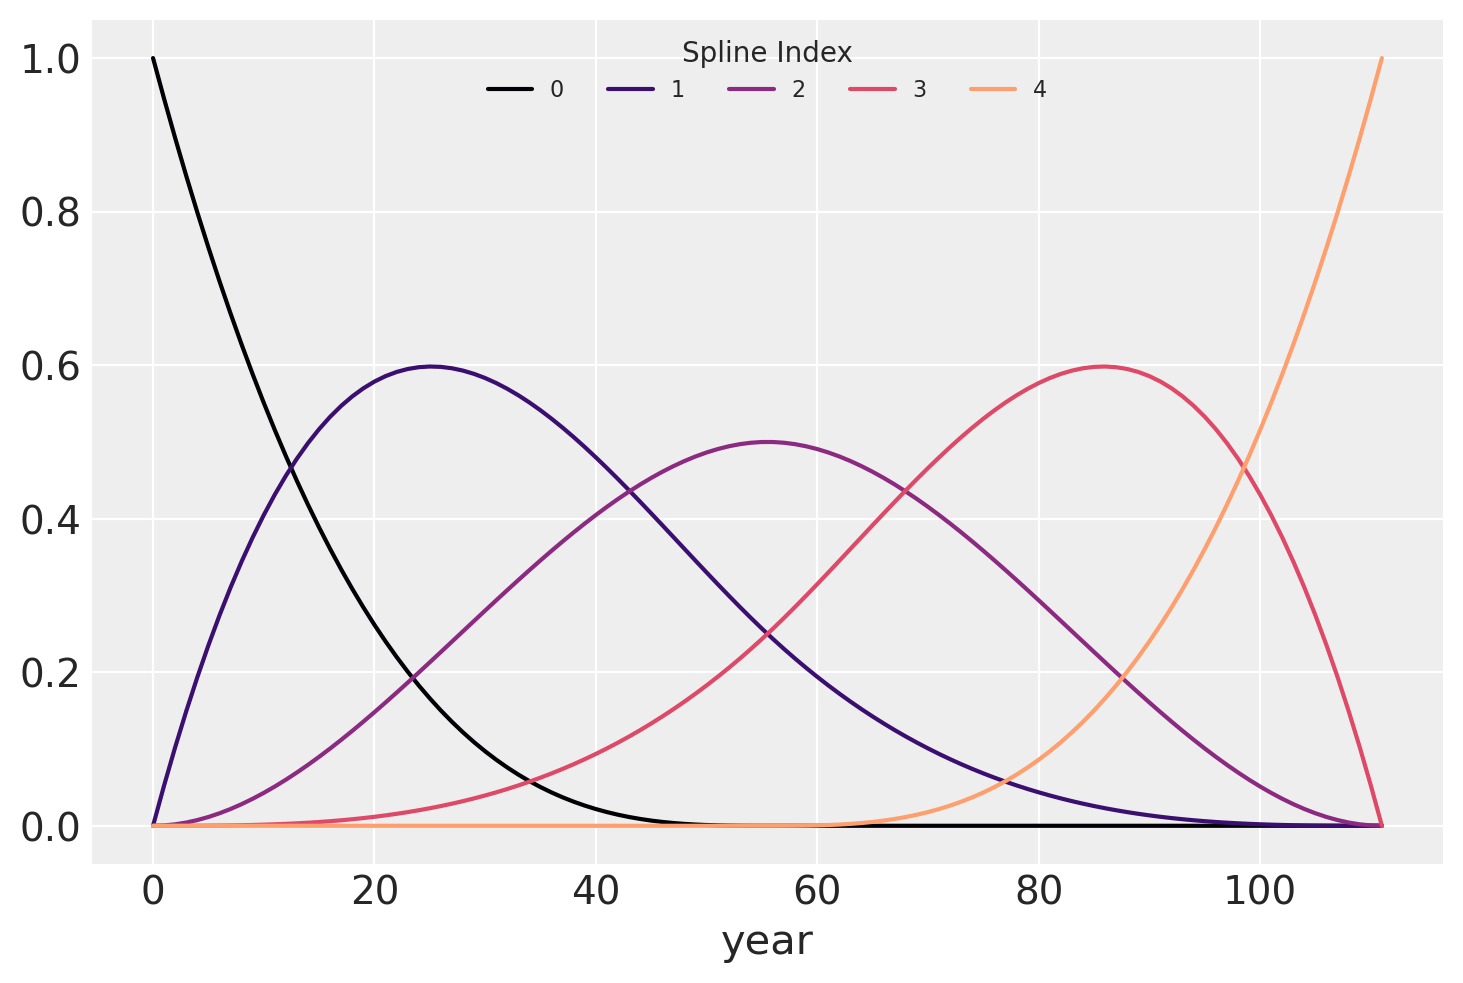

In [143]:
spline_df = (
    pd.DataFrame(B)
    .assign(year=gdp_data.date_num.values)
    .melt("year", var_name="spline_i", value_name="value")
)

color = plt.cm.magma(np.linspace(0, 0.80, len(spline_df.spline_i.unique())))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("year", "value", c=c, ax=plt.gca(), label=i)
plt.legend(title="Spline Index", loc="upper center", fontsize=8, ncol=6);

In [153]:
COORDS = {"splines": np.arange(B.shape[1])}
with pm.Model(coords=COORDS) as spline_model1:
    a = pm.Normal("a", 100, 100)
    w = pm.Normal("w", mu=0, sigma=3, size=B.shape[1], dims="splines")
    mu = pm.Normal("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=gdp_data.gdp_total) ####

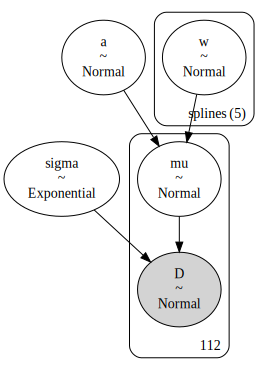

In [154]:
pm.model_to_graphviz(spline_model1)

In [155]:
with spline_model1:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws=1000, tune=1000, random_seed=RANDOM_SEED, chains=4))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [D, a, mu, sigma, w]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 372 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [D]


In [156]:
az.summary(idata, var_names=["a", "w", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,34.790,52.594,-63.145,130.639,12.645,9.096,17.0,139.0,1.16
w[0],32.948,89.902,-145.050,197.623,15.636,11.155,35.0,64.0,1.08
w[1],-26.328,70.923,-154.493,110.546,18.585,13.415,15.0,203.0,1.19
w[2],-24.648,80.814,-186.244,119.079,24.828,18.063,11.0,23.0,1.29
w[3],-35.501,77.858,-171.225,115.901,20.526,14.819,15.0,76.0,1.20
w[4],76.823,98.065,-121.567,238.188,26.515,19.164,14.0,68.0,1.23
sigma,14502.233,70.320,14369.033,14630.286,1.945,1.376,1310.0,1807.0,1.00


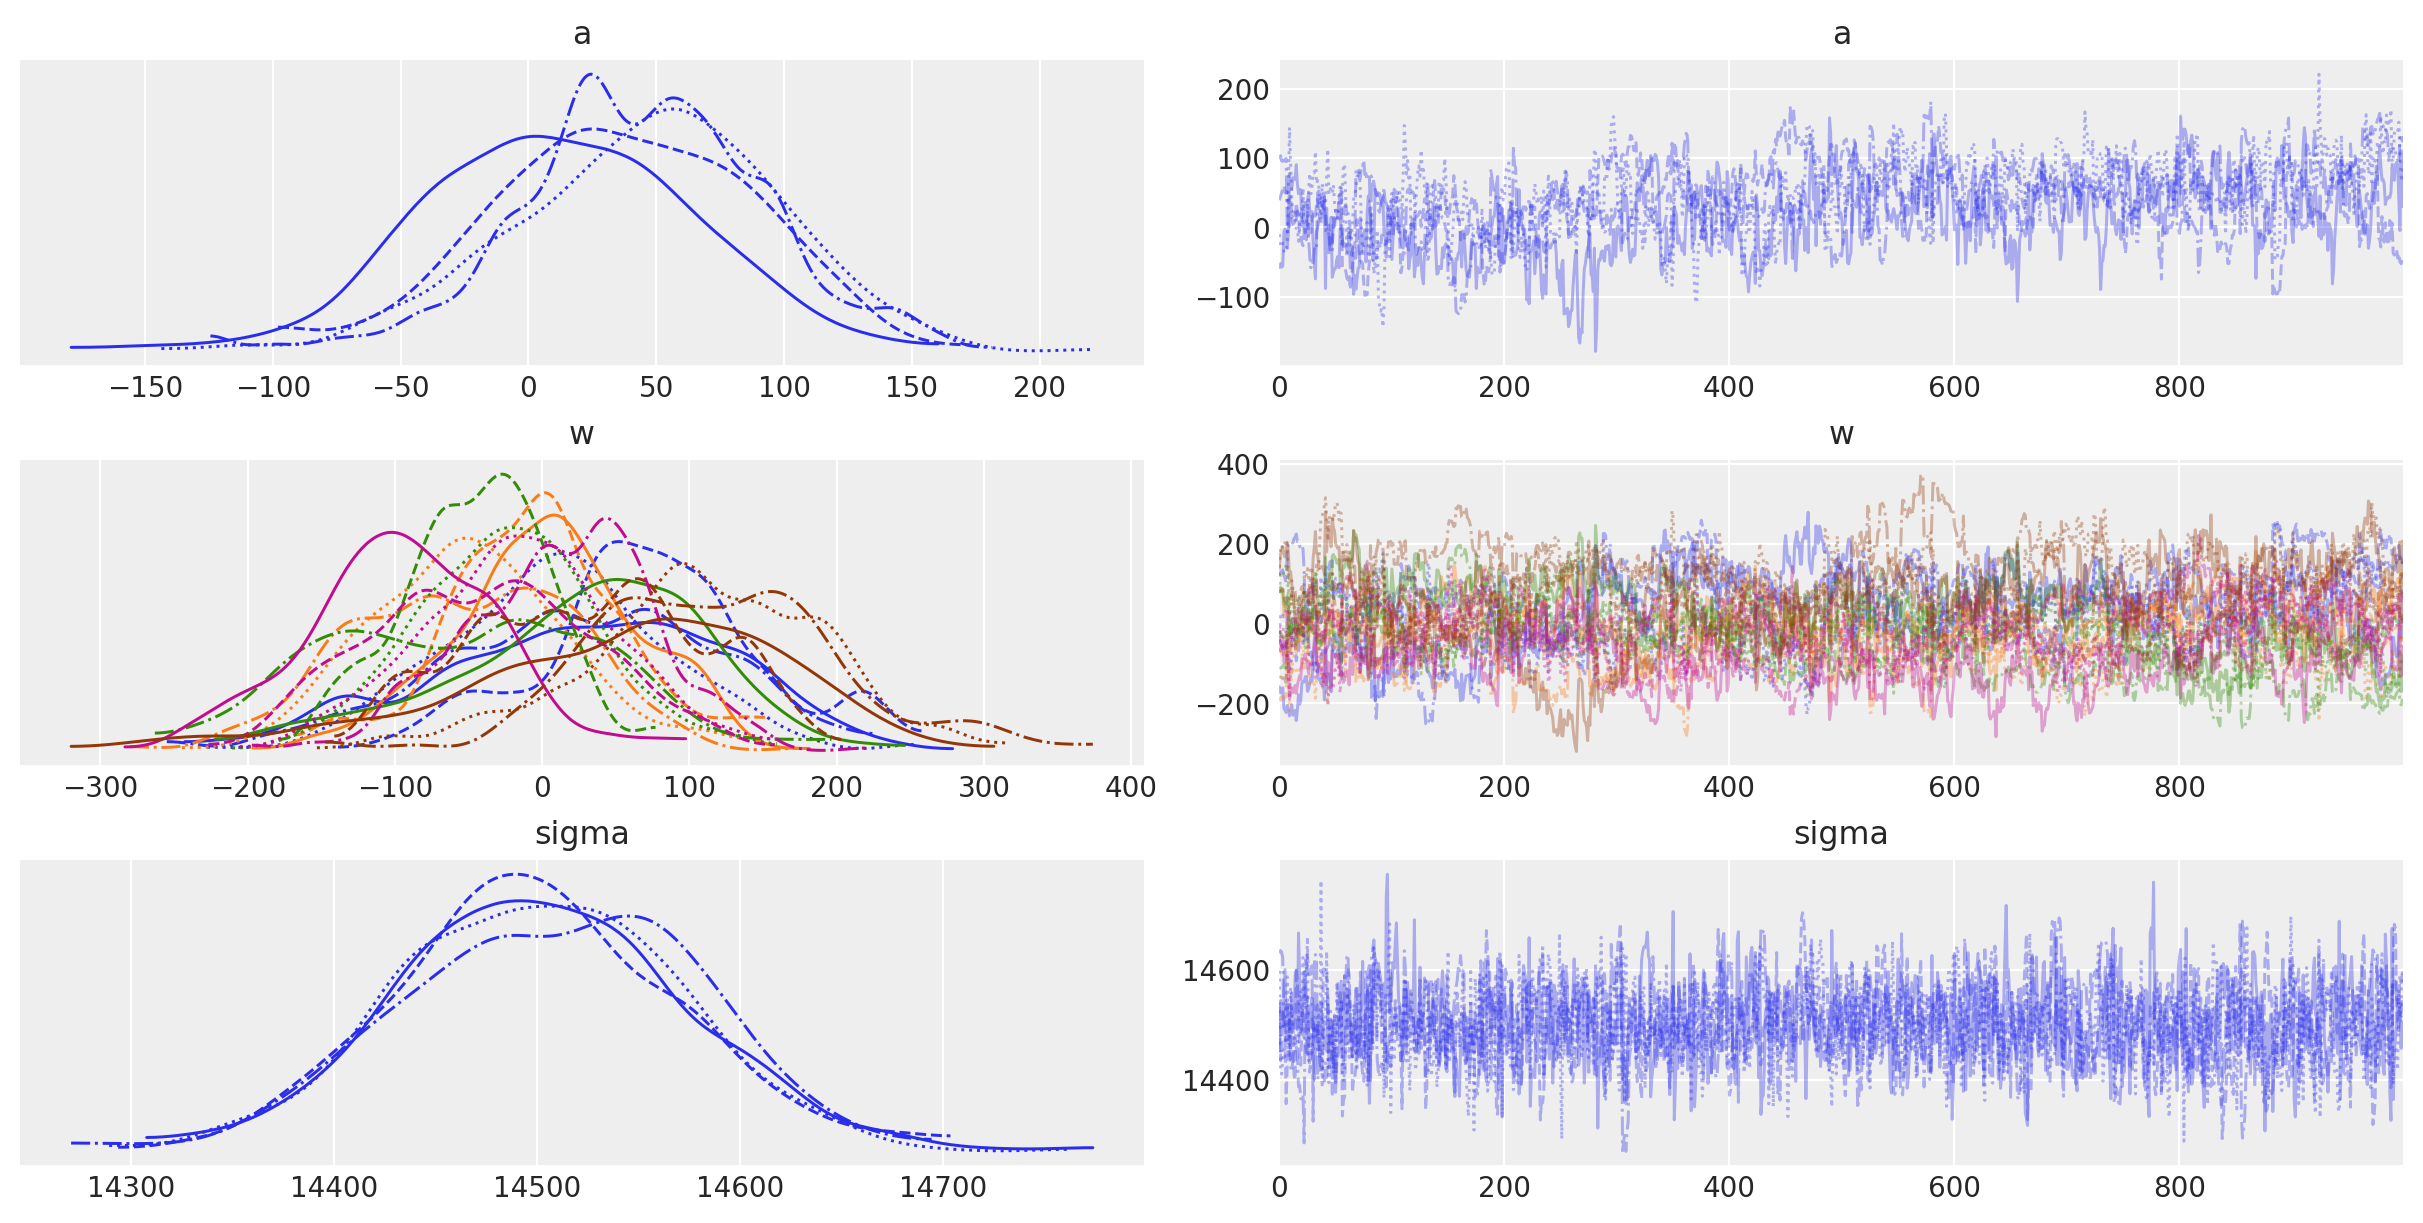

In [157]:
az.plot_trace(idata, var_names=["a", "w", "sigma"]);

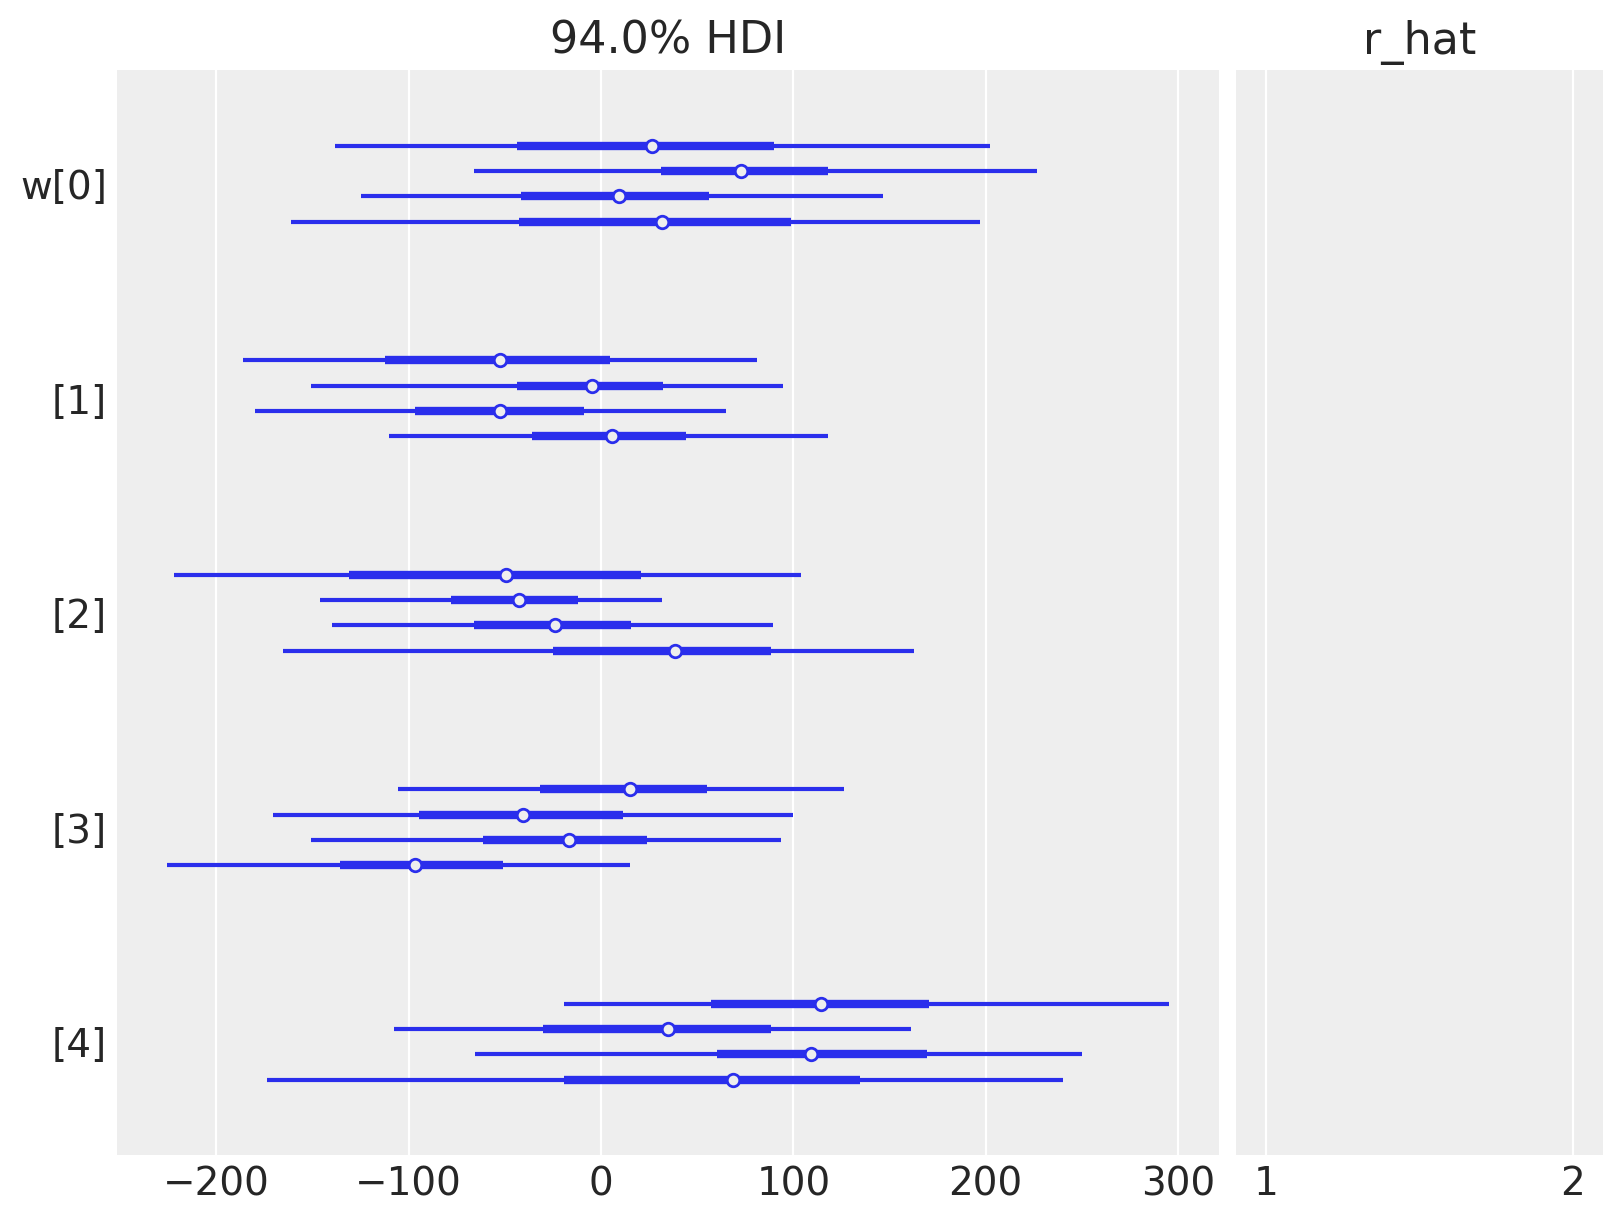

In [158]:
az.plot_forest(idata, var_names=["w"], combined=False, r_hat=True);

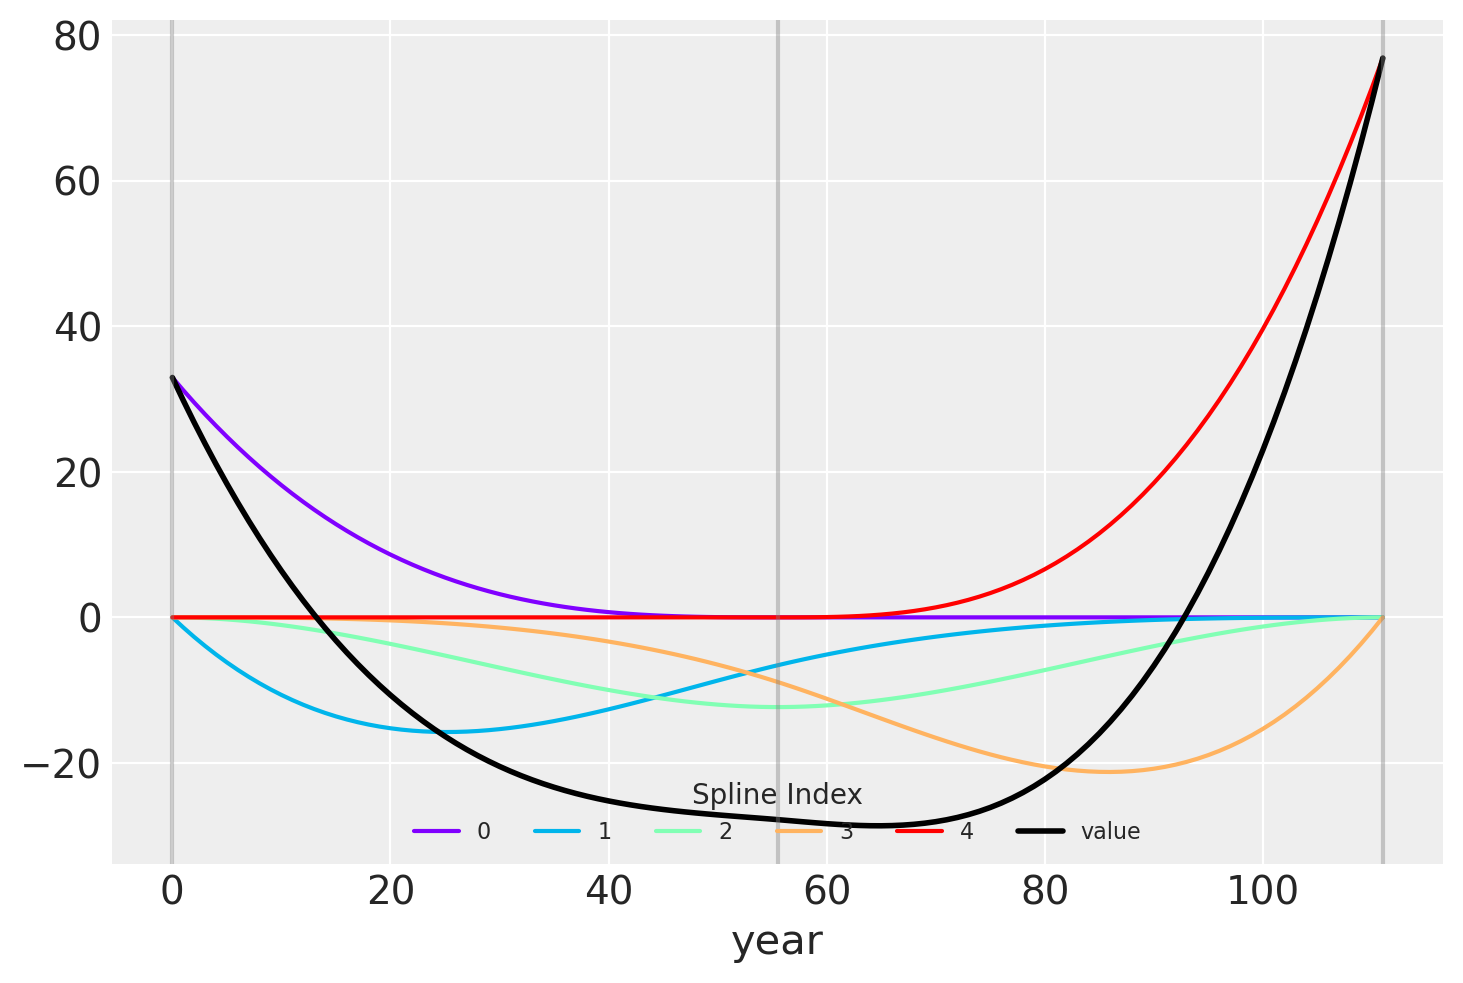

In [159]:
wp = idata.posterior["w"].mean(("chain", "draw")).values

spline_df = (
    pd.DataFrame(B * wp.T)
    .assign(year=gdp_data.date_num.values)
    .melt("year", var_name="spline_i", value_name="value")
)

spline_df_merged = (
    pd.DataFrame(np.dot(B, wp.T))
    .assign(year=gdp_data.date_num.values)
    .melt("year", var_name="spline_i", value_name="value")
)


color = plt.cm.rainbow(np.linspace(0, 1, len(spline_df.spline_i.unique())))
fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("year", "value", c=c, ax=plt.gca(), label=i)
spline_df_merged.plot("year", "value", c="black", lw=2, ax=plt.gca())
plt.legend(title="Spline Index", loc="lower center", fontsize=8, ncol=6)

for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

In [160]:
post_pred = az.summary(idata, var_names=["mu"]).reset_index(drop=True)
gdp_data_post = gdp_data.copy().reset_index(drop=True)
gdp_data_post["pred_mean"] = post_pred["mean"]
gdp_data_post["pred_hdi_lower"] = post_pred["hdi_3%"]
gdp_data_post["pred_hdi_upper"] = post_pred["hdi_97%"]

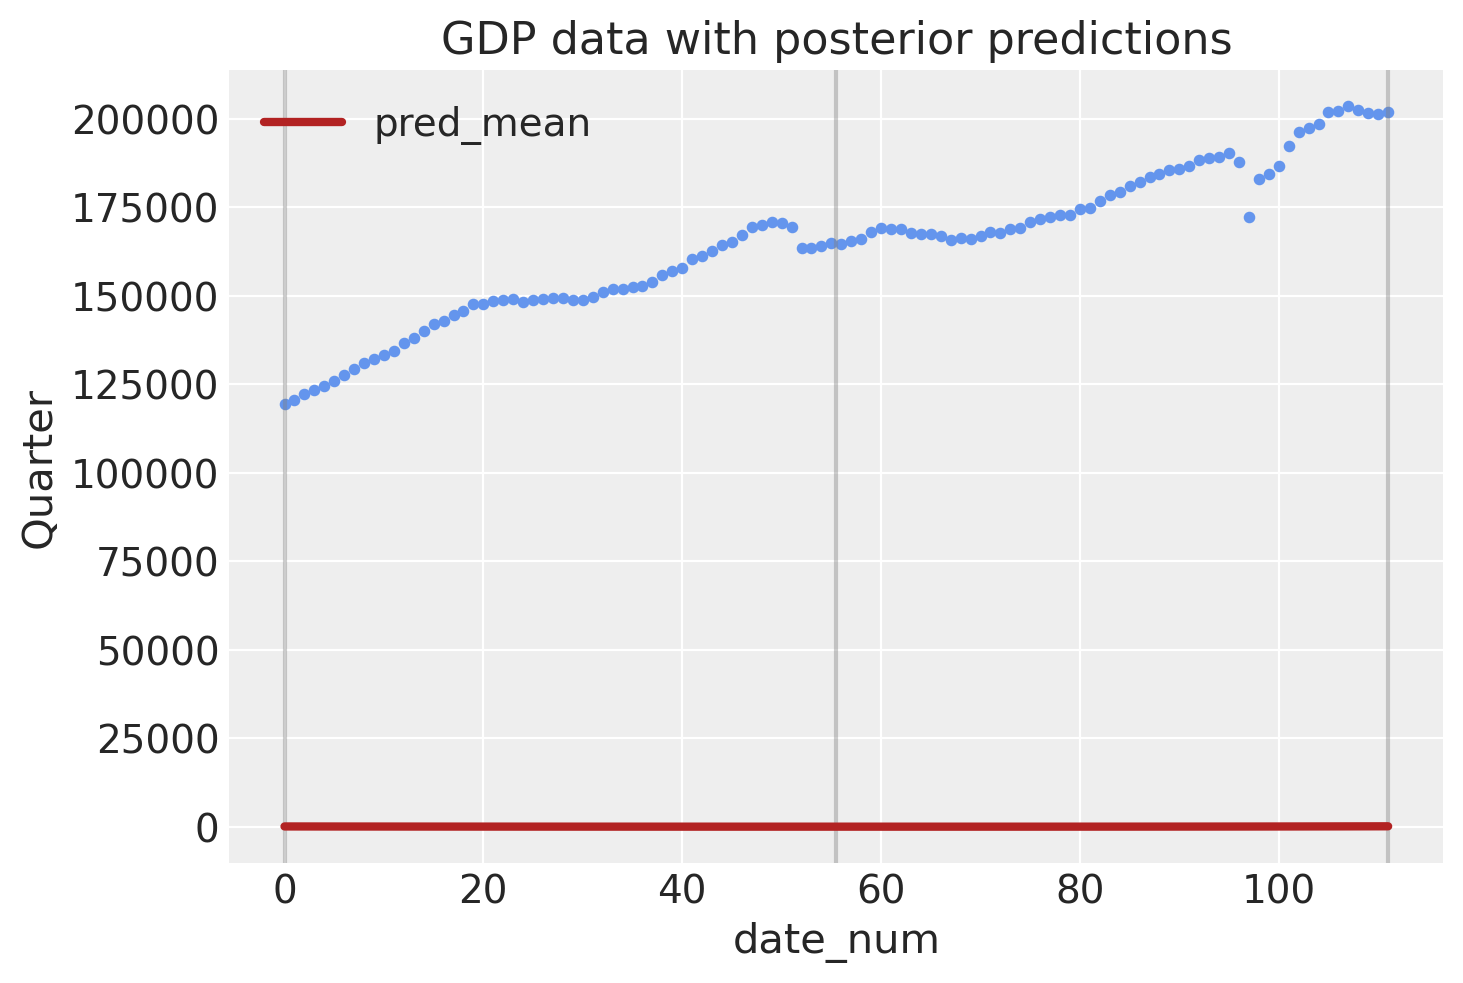

In [163]:
gdp_data_post.plot.scatter(
    "date_num",
    "gdp_total",
    color="cornflowerblue",
    s=10,
    title="GDP data with posterior predictions",
    ylabel="Quarter",
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4)

gdp_data_post.plot("date_num", "pred_mean", ax=plt.gca(), lw=3, color="firebrick")
plt.fill_between(
    gdp_data_post.date_num,
    gdp_data_post.pred_hdi_lower,
    gdp_data_post.pred_hdi_upper,
    color="firebrick",
    alpha=0.4,
);